## <span style="color:magenta">Привет, Александр!</span>

Меня зовут **Александр Сушков** и я буду проверять твой проект. Если не против, я буду обращаться к тебе на "ТЫ". Если это неприемлемо, обязательно напиши мне в комментариях - мы прейдем на "ВЫ".

Спасибо, что сдал задание:) Ты проделал большую работу. Далее в файле ты сможешь найти мои комментарии в подобных ячейках. Пострайся учесть эти комментарии в ходе выполнения дальнейших проектов.

Мне очень понравился твой проект. Видно, что ты достаточно проработал теоритическую часть. Я вижу, что ты интересуешься материалом, которого не было, или пока не было, в теоритической части Практикума. Это очень здОрово! Тем не менее, в проекте обнаружились недочёты, которые необходимо будет исправить. Это не плохо, это - нормально.

Обрати внимание, для твоего удобства, я буду выделять свои комментарии цветом, в зависимости от того, какие действия, важность и особенности тебя ждут в процессе проверки:
<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 
    
Такими комментариями я буду помечать хорошо проделаную работу, а так же хорошо проделаную работу над ошибками:)
</div>

<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 
    
В таких комментариях я постараюсь подсказать тебе более элегантное или легкое решение. Поскажу некоторые хитрости и фишки. Дам рекомендации на будущее, ссылки для доп. изучения. Части проекта, помеченные такими комментариями, можно не исправлять, но рекомендую обратить на них внимание.
</div>

<div class="alert alert-block alert-danger">
<h2>Комментарий от ревьювера (недочет, который нужно доработать)</h2> 
    
Если ты видишь такой комментарий, значит я указываю тебе на недочёт, его нужно исправить. Без такого исправления я не приму твою работу:)
</div>

#### Пожалуста, не удаляй мои комментарии и относись к ним бережно. При повторной проверке, я буду ориентироваться на них. 

###### Можешь под моими комментариями оставлять свои, в которых опиши свои испарвления. Это облегчит процесс проверки и мне, и тебе:) Например, вот так:

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА:</b>
</div>

## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

<div class="alert alert-block alert-danger">
<h2>Комментарий от ревьювера (недочет, который нужно доработать)</h2> 

Немного про оформление:) Ты просто скопировал задание себе в тетрадку. В некоторых случаях это тоже выход:) Но я бы порекомендовал тебе составлять план, похожий больше на книжное содержание.
Например:

### Определение чего-то очень важного.
_____
##### В данном исследовании представлены несколько таблиц с очень важной информацией.
______

###### Данное исследование разделим на несколько частей.

##### Часть 1. Изучение общей информации:
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)

##### Часть 2. Подготовка данных:
* [1. Приведение данных к нужным типам.](#3-bullet)
* [2. Нахождение и исправление аномалий и ошибок.](#4-bullet)

и т.д

Старайся выполнять свой проект в порядке, прописанном в твоем плане. Да, такое оформление займет больше времени, но позволит тебе не путаться в будущем:)
_________________

Обрати внимание, что пункты в частях у меня в виде ссылок. Это очень удобно, когда нужно переходить по разным частям проекта.
Вот тут почитай, как сделать <a href="https://sebastianraschka.com/Articles/2014_ipython_internal_links.html">кликабельные разделы</a>

**Почему это важно?** Когда ты будешь в будущем выполнять тестовые задания, просто скопировав присланную тебе задачу и не составив плана, ты можешь смутить будущего работодателя. А грамотно сконфигурированный план покажет тебя как ответсвенного и усидчивого специалиста. И, просто поверь мне, с расписанием легче:)

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

data = pd.read_csv('/datasets/data.csv')

data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

- Столбцы <b>days_employed</b> и <b>total_income</b> имеют пропущенные значения, причем их количество совпадает
- Столбец <b>days_employed</b> содержит отрицательные значения. Это поле также имеет дробные значения, что недопустимо для стажа.
- Значение в <b>столбце education</b> записаны в разных регистрах
- Значение в столбцах указаны на русском языке, однако поле gender содержит английские аббревиатуры 

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Отлично! Замечательные выкладки. Молодец что используешь только метод info. значит понимаешь, как он работает. Другие методы, shape, isnull и т.д. -  это уже избыточно)

### Шаг 2. Предобработка данных

### Обработка пропусков

In [3]:
data['days_employed'].isna().sum()

2174

In [4]:
data['total_income'].isna().sum()

2174

In [5]:
data[data['days_employed'].isna()]['total_income'].isna().sum()

2174

Пустые значение в обоих полях совпадают

In [6]:
data[data['days_employed'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Других закономерностей не обнаружено

In [7]:
def present(count_100_percent, count__x_percent):
    return 100/ (count_100_percent / count__x_percent)

In [8]:
present(len(data), data['days_employed'].isna().sum())

10.099883855981417

Пропущено 10% данных, довольно большой процент. Пропуски необходимо заполнить предварительно изучив и исправив значения в столбцах.

In [9]:
present(len(data), data[ data['days_employed'] < 0]['days_employed'].count())

73.89547038327527

Почти все значения отрицательные, скорее всего, ошибка заполнения.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Согласен)

In [10]:
data['days_employed'] = abs(data['days_employed'])

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Отличный метод)

In [11]:
data.loc[data['days_employed'].notna(),'days_employed'] = data[data['days_employed'].notna()]['days_employed'].astype('int')

In [12]:
data['max_days_employed'] = (data['dob_years'] - 12) * 365.25 
def count_present_live_less_than_job(): 
    live_less_than_job = data.loc[data['max_days_employed'] < data['days_employed']]['days_employed'].count()
    return present(len(data), live_less_than_job)

In [13]:
count_present_live_less_than_job()

16.362369337979093

По закону, люди могут работать только с 12 лет. Трудовой стаж больше периода, в течении которого, человек может работать - ошибка. Таких 16.3 процента.

In [14]:
data.drop(data.loc[data['max_days_employed'] < data['days_employed']].index,inplace=True)
count_present_live_less_than_job()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  


0.0

In [15]:
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())
count_present_live_less_than_job()

0.05554629783924902

In [16]:
data.drop(data.loc[data['max_days_employed'] < data['days_employed']].index,inplace=True)
count_present_live_less_than_job()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  


0.0

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Отличная часть, замечательная логика, все на высоте молодец)

<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 
    
Смотри, предупреждения. Это юпитер предупреждает что ты делишь на ноль (и действительно, в функции получается еление на ноль))
    
Чтоб такие предупреждения не доставали, можно их отключить прописав при импорте во такую конструкцию
    
    import warnings
    
    warnings.filterwarnings('ignore')
</div>

#### Поле total_income

In [17]:
data.groupby('income_type')['total_income'].mean()

income_type
в декрете           53829.130729
госслужащий        171008.225815
компаньон          202483.482019
пенсионер                    NaN
предприниматель    499163.144947
сотрудник          161390.227204
студент             98201.625314
Name: total_income, dtype: float64

Доход пенсионеров не заполнен вообще

In [18]:
mean_by_income_type = data.groupby('income_type')['total_income'].transform('mean')

In [19]:
data['total_income'] = data['total_income'].fillna(mean_by_income_type)

Остались пенсионеры для них среднее не опреденено. Смоделируем доход с помощью нормального распределения со средним значением пенсии 14 904 и дисперсией 5 000.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Замечательно, замена по типу дохода - самый оптимальный вариант. Все выкладки логичны - молодец)

<div class="alert alert-block alert-danger">
<h2>Комментарий от ревьювера (недочет, который нужно доработать)</h2> 
    
Возьми ручку и бумагу, сто раз напиши "При ликвидации пропуков я никогда не буду использовать среднее, только медиану" Шутка! Но среднее на самом деле лучше не использовать, оно очень чувствительно к выбросам)
</div>

In [20]:
import random
data['total_income'] = data['total_income'].fillna(random.normalvariate(14904, 5000))

In [21]:
data.groupby('income_type')['total_income'].mean()

income_type
в декрете           53829.130729
госслужащий        171008.225815
компаньон          202483.482019
пенсионер           17233.804701
предприниматель    499163.144947
сотрудник          161390.227204
студент             98201.625314
Name: total_income, dtype: float64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17993 entries, 0 to 21524
Data columns (total 13 columns):
children             17993 non-null int64
days_employed        17993 non-null float64
dob_years            17993 non-null int64
education            17993 non-null object
education_id         17993 non-null int64
family_status        17993 non-null object
family_status_id     17993 non-null int64
gender               17993 non-null object
income_type          17993 non-null object
debt                 17993 non-null int64
total_income         17993 non-null float64
purpose              17993 non-null object
max_days_employed    17993 non-null float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.9+ MB


### Вывод

Два поля содержали пустые значения (<b>days_employed</b> и <b>total_income</b>). Поле <b>days_employe</b> содержало записи, где трудовой стаж превышал период, в течении которого, человек может работать, такие данные были удалены. Пустые значения заменены на медиану, так — как трудовой стаж в днях — это переменная целого типа, тогда как средние может быть дробным (считая вещественную часть ошибкой при выгрузки данных). Для замены пустых значений в поле  <b>total_income</b>, данные были сгруппированы по полю <b>income_type</b> так, как средняя зарплата студента существенно отличается от средней предпринимателя. Пустые значения заменены  средним из соответствующей категории.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Отличная предобработка. Хочу отметить замечательные рассуждения и прекрасные выводы. Все исследования очень подробные, подобраны правильные категории. Выше всяких похвал, молодец, мастерский анализ)

### Замена типа данных

In [23]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,max_days_employed
0,1,8437.0,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,10957.50
1,1,4024.0,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,8766.00
2,0,5623.0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,7670.25
3,3,4124.0,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,7305.00
5,0,926.0,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,5478.75


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17993 entries, 0 to 21524
Data columns (total 13 columns):
children             17993 non-null int64
days_employed        17993 non-null float64
dob_years            17993 non-null int64
education            17993 non-null object
education_id         17993 non-null int64
family_status        17993 non-null object
family_status_id     17993 non-null int64
gender               17993 non-null object
income_type          17993 non-null object
debt                 17993 non-null int64
total_income         17993 non-null float64
purpose              17993 non-null object
max_days_employed    17993 non-null float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.9+ MB


In [25]:
data['days_employed'] = data['days_employed'].astype('int')

In [26]:
data['debt'].unique()

array([0, 1])

In [27]:
data['debt'] = data['debt'].astype('bool')

In [28]:
data['max_days_employed'] = data['max_days_employed'].astype('int')

### Вывод

Столбцам, содержащим количество дней, присвоен тип <b>int</b> — целое число, а столбцу <b>debt</b> тип <b>bool</b>, который более точно отражает значение поля.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Можно и так, хотя я бы debt не трогал, но то, как ты сделал - не ошибка)

### Обработка дубликатов

#### Поле children

In [29]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [30]:
present(len(data), data[ data['children'] == -1]['children'].count())

0.22230867559606515

Ошибка заполнения

In [31]:
data.loc[data['children'] == -1,'children'] = 1

<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 
    
Старайся в таких случаях использовать abs()
</div>

In [32]:
data['children'].unique()

array([ 1,  0,  3,  2,  4, 20,  5])

#### Поле education

In [33]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'], dtype=object)

In [34]:
data['education'] = data['education'].str.lower()

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Правильный метод - молодец)

In [35]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

#### Поле education_id

In [36]:
data['education_id'].unique()

array([0, 1, 2, 3, 4])

In [37]:
data.groupby('education')['education_id'].mean()

education
высшее                 0
начальное              3
неоконченное высшее    2
среднее                1
ученая степень         4
Name: education_id, dtype: int64

Средние разные и целые, следовательно, поле не содержит ошибок

#### Поле family_status

In [38]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'в разводе',
       'Не женат / не замужем', 'вдовец / вдова'], dtype=object)

In [39]:
data['family_status'] = data['family_status'].str.lower()

In [40]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'в разводе',
       'не женат / не замужем', 'вдовец / вдова'], dtype=object)

#### Поле family_status_id

In [41]:
data.groupby('family_status')['family_status_id'].mean()

family_status
в разводе                3
вдовец / вдова           2
гражданский брак         1
женат / замужем          0
не женат / не замужем    4
Name: family_status_id, dtype: int64

Средние разные и целые, следовательно, поле не содержит ошибок

#### Поле gender

In [42]:
data['gender'].value_counts()

F      11370
M       6622
XNA        1
Name: gender, dtype: int64

Скорее всего, XNA - это пустое значение. Заменим его на M, так как мужчин  меньше

In [43]:
data['gender'] = data['gender'].replace('XNA','M')

In [44]:
data['gender'].value_counts()

F    11370
M     6623
Name: gender, dtype: int64

#### Поле income_type

In [45]:
data['income_type'].unique()

array(['сотрудник', 'компаньон', 'пенсионер', 'госслужащий',
       'предприниматель', 'студент', 'в декрете'], dtype=object)

<b>Остальные поля рассмотрены ранее</b>

### Вывод

Каждое поле было изучено и обработано отдельно, в соответствии с ошибкой в нем

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Всё супер - хорошая работа)

### Лемматизация

In [46]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'операции с жильем', 'образование',
       'на проведение свадьбы', 'покупка жилья для семьи',
       'покупка недвижимости', 'покупка коммерческой недвижимости',
       'сыграть свадьбу', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку своего автомобиля',
       'на покупку подержанного автомобиля',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'операции с коммерческой недвижимостью', 'свой автомобиль',
       'сделка с автомобилем', 'профильное образование',
       'высшее об

In [47]:
from pymystem3 import Mystem
m = Mystem()

data['purpose_lemm'] = data['purpose'].apply(m.lemmatize)

In [48]:
data['purpose_lemm'].head()

0                 [покупка,  , жилье, \n]
1       [приобретение,  , автомобиль, \n]
2                 [покупка,  , жилье, \n]
3    [дополнительный,  , образование, \n]
5                 [покупка,  , жилье, \n]
Name: purpose_lemm, dtype: object

In [49]:
def categorization(list_lemms):
    if 'образование' in list_lemms:
        return 'образование'
    if 'свадьба' in list_lemms:
        return 'свадьба'
    if 'ремонт' in list_lemms:
        return 'ремонт'
    if 'автомобиль' in list_lemms:
        return 'покупка автомобиля'
    if 'строительство' in list_lemms:
        return 'строительство'
    """
    if 'покупка' in list_lemms:
        if 'жилье' or 'недвижимость' in list_lemms:
            return 'покупка недвижимости'
    """
    return 'операции с недвижимостью'

In [50]:
data['categories'] = data['purpose_lemm'].apply(categorization)

In [51]:
data[data['categories'].isna()]['purpose'].unique()

array([], dtype=object)

### Вывод

Входе лемматизации цени кредита были укрупнены, в соответствии, со смыслом.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Очень элегантное решение.Самая сложная часть решена)

### Категоризация данных

#### Группировка по наличию детей

In [52]:
def with_child_or_not(children):
    if children > 0:
        return 'с детьми'
    return 'бездетные'

In [53]:
data['with_child_or_not'] = data['children'].apply(with_child_or_not)

#### Группировка по наличию сожителя

In [54]:
data.groupby('family_status')['family_status_id'].mean().reset_index().sort_values(['family_status_id'])

,family_status,family_status_id
3,женат / замужем,0
2,гражданский брак,1
1,вдовец / вдова,2
0,в разводе,3
4,не женат / не замужем,4


In [55]:
def married(family_status_id):
    if family_status_id < 2:
        return 'в браке'
    return 'одинок'    

In [56]:
data['married'] = data['family_status_id'].apply(married)

#### Группировка по уровню дохода

In [57]:
def income_level(income):
    if income < 60000:
        return 'ниже среднего'
    if income < 120000:
        return 'средний класс'
    if income < 200000:
        return 'выше среднего'
    return 'богатые'

In [58]:
data['income_level'] = data['total_income'].apply(income_level)

### Вывод

Для ответа на поставленные вопросы, данные были сгруппированы по наличию детей, семейному положению и уровню дохода.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Все верно, отличная категоризация. Для некоторых категорий можно обращаться к внешним источникам, например, к сайту Росстата для определния категории по доходу)

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [59]:
pivot_children = pd.pivot_table(data, values=['income_level'], index='with_child_or_not', columns='debt', aggfunc='count')

In [60]:
pivot_children = pivot_children.reset_index()

In [61]:
pivot_children

with_child_or_not income_level     
debt                          False True
0            бездетные        10049  892
1             с детьми         6392  660

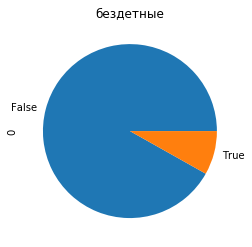

In [62]:
pivot_children['income_level'].loc[0].plot(kind='pie', y='income_level', title='бездетные')

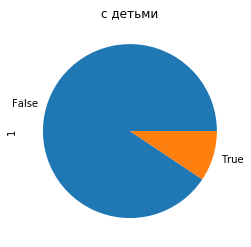

In [63]:
pivot_children['income_level'].loc[1].plot(kind='pie', y='income_level', title='с детьми')

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Ну вот это просто шикарно) Молодец, что разобрался с визуализацией, выше всяких похвал. Очень наглядно и информативно)


<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 
    
Поставь в каждый график параметр autopct='%1.1f%%', посмотришь как круто получится)
</div>

### Вывод

Круговые диаграммы примерно одинаковые, следовательно наличие детей не влияет на возврат кредита в срок.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [64]:
pivot_married = pd.pivot_table(data, values=['income_level'], index='married', columns='debt', aggfunc='count')

In [65]:
pivot_married = pivot_married.reset_index()

In [66]:
pivot_married

married income_level      
debt                 False  True
0     в браке        12856  1186
1      одинок         3585   366

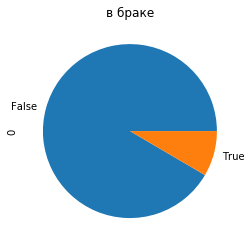

In [67]:
pivot_married['income_level'].loc[0].plot(kind='pie', y='income_level', title='в браке')

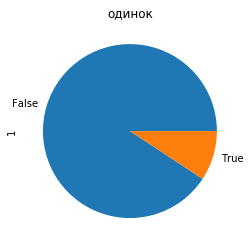

In [68]:
pivot_married['income_level'].loc[1].plot(kind='pie', y='income_level', title='одинок')

### Вывод

Круговые диаграммы примерно одинаковые, следовательно семейное положение не влияет на возврат кредита в срок.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [69]:
pivot_income_level = pd.pivot_table(data, values=['married'], index='income_level', columns='debt', aggfunc='count')

In [70]:
pivot_income_level = pivot_income_level.reset_index()

In [71]:
pivot_income_level

income_level married     
debt                  False True
0           богатые    4642  356
1     выше среднего    6815  698
2     ниже среднего     794   66
3     средний класс    4190  432

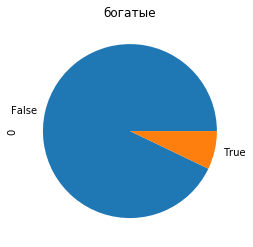

In [72]:
pivot_income_level['married'].loc[0].plot(kind='pie', y='married', title='богатые')

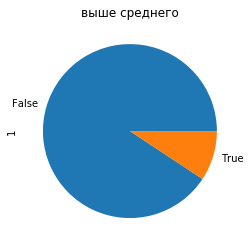

In [73]:
pivot_income_level['married'].loc[1].plot(kind='pie', y='married', title='выше среднего')

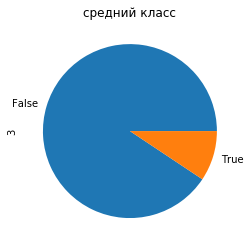

In [74]:
pivot_income_level['married'].loc[3].plot(kind='pie', y='married', title='средний класс')

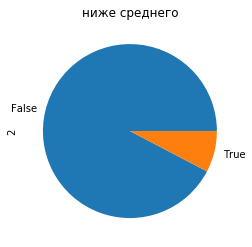

In [75]:
pivot_income_level['married'].loc[2].plot(kind='pie', y='married', title='ниже среднего')

### Вывод

Круговые диаграммы примерно одинаковые, следовательно уровень дохода не влияет на возврат кредита в срок.

- Как разные цели кредита влияют на его возврат в срок?

In [76]:
pivot_categories = pd.pivot_table(data, values=['income_level'], index='categories', columns='debt', aggfunc='count')

In [77]:
pivot_categories = pivot_categories.reset_index()

In [78]:
pivot_categories

categories income_level     
debt                                  False True
0                  образование         3028  328
1     операции с недвижимостью         6468  542
2           покупка автомобиля         3223  358
3                       ремонт          488   31
4                      свадьба         1795  165
5                строительство         1439  128

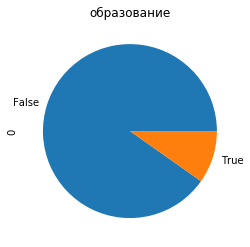

In [79]:
pivot_categories['income_level'].loc[0].plot(kind='pie', y='income_level', title='образование')

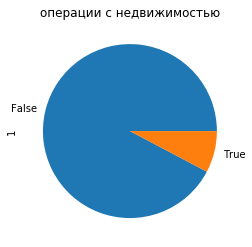

In [80]:
pivot_categories['income_level'].loc[1].plot(kind='pie', y='income_level', title='операции с недвижимостью')

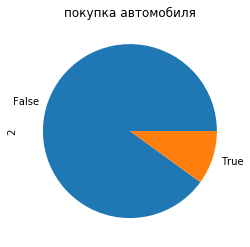

In [81]:
pivot_categories['income_level'].loc[2].plot(kind='pie', y='income_level', title='покупка автомобиля')

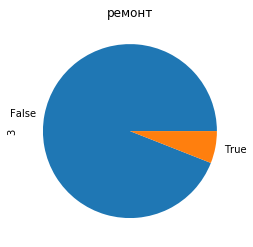

In [82]:
pivot_categories['income_level'].loc[3].plot(kind='pie', y='income_level', title='ремонт')

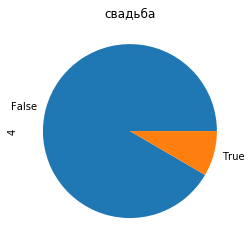

In [83]:
pivot_categories['income_level'].loc[4].plot(kind='pie', y='income_level', title='свадьба')

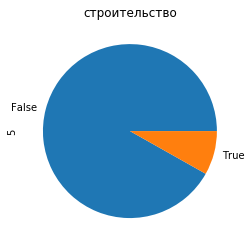

In [84]:
pivot_categories['income_level'].loc[5].plot(kind='pie', y='income_level', title='строительство')

### Вывод

Круговые диаграммы примерно одинаковые, --- дохода не влияет на возврат кредита в срок.

<div class="alert alert-block alert-success">
<h2>Комментарий от ревьювера (все здОрово)</h2> 

Обалденная часть, просто молодец, все расчеты верные. Ты справился с работой просто на отлично.

<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 
    
Ты зря расстроился, все круто, все расчеты верные. Для наглядности я тебе порекомендую:
    
1. Добавь тот параметр в графики, сразу проект заиграет красками другими.
    
2. Ты прекрасно освоил сводные таблицы, добавь в каждую третий столбец, где будет расчитываться процент должников и будуь видны все косяки заемщиков)
</div>

### Шаг 4. Общий вывод

Что — то не так, надо все переделывать )

## <span style="color:magenta">В заключении) </span>

Ты молодец! Все у тебя верно, выполни рекомендации и сможешь написать вывод)  Все рассуждения верные. Очень логичные и осмысленные. Ничего лишнего, все по полкам. 

Ты показываешь хорошее владение всем изучаемым в модуле материалом. Уверенно пользуешься pandas, строишь отличные наглядные таблички, отличные визуализации. Делаешь четкие обоснованные выводы.

Поисправляй недочеты, и проект будет просто класс!

Короче, молодец! Жду твоих исправлений)

<img src="https://avatars.mds.yandex.net/get-pdb/2402172/12f53009-3c0e-4655-87c6-606d139bbf8e/s1200?webp=false" width="300">

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.